**Reinforcement Learning with TensorFlow & TRFL: Distributional Deep Q Networks**
* Further modify Deep Q Networks (DQN) with Distributional Q Learning and Distributional Double Q Learning

Outline:
1. Distributional Q learning explanation
2. Distributional Q learning example
3. Distributional Double Q learning example


In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [1]:
#install TRFL
!pip install trfl==1.0

#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

In [0]:
import gym
import tensorflow as tf
import numpy as np
env = gym.make("CartPole-v0")

** Distributional Q Learning **

Q learning estimates action values with a scalar. Distributional Q learning provides an estimate over a distribution. TRFL implements categorical distributional Q learning (the C51 algorithm) with trfl.categorical_dist_qlearning(). In categorical distributional Q learning we have a train distribution and a target distribution. We get the next state distribution from the target, discount it, and add a reward to it. Then we project the modified target distribution onto the train distribution support. We minimize cross-entropy loss between the two distributions as the network trains. The train distribution support is initially set by the atom values.



In [0]:
#Code used from: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
#Distributional code: https://github.com/unixpickle/anyrl-py/blob/master/anyrl/models/dqn_dist.py
#https://github.com/flyyufelix/C51-DDQN-Keras/blob/master/c51_ddqn.py#

import trfl

class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20, num_atoms=51, atom_min=-2.,atom_max=10.):

        with tf.variable_scope(name):
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.name = name
            
            #get the logits for the Distributional DQN
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size * num_atoms, 
                                                            activation_fn=None)
            #reshape output into distibutional logits (batch size x actions x num_atoms)
            self.logits_ = tf.reshape(self.output, [batch_size, action_size, num_atoms])
            
            #get atom values
            self.atom_values = self.get_atoms(num_atoms, atom_min, atom_max)
            self.atom_ = tf.constant(self.atom_values,dtype=tf.float32,shape=[num_atoms])
      
            #get action values
            #TRFL does the softmax to self.logits. We are not using TRFL to get greedy action so need to add here
            self.normalized_values = tf.nn.softmax(self.logits_, axis=-1)
            #reduce sum over atoms, left with batch_size x action size. Can take argmax to get greedy actions
            self.action_values_ = tf.reduce_sum(self.normalized_values*self.atom_, axis=-1)
  
            #TRFL placeholders
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.target_logits_ = tf.placeholder(tf.float32, [batch_size,action_size,num_atoms], name='target')
            self.target_atom_ = tf.placeholder(tf.float32,[num_atoms])
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            
            #TRFL distributional Q learning
            qloss, q_learning = trfl.categorical_dist_qlearning(self.atom_, self.logits_, self.action_, self.reward_,
                                                                self.discount_, self.target_atom_, self.target_logits_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
                      
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]
    
    #set up the atom tensor for the self.atom_ constant
    def get_atoms(self, num_atoms, atom_min, atom_max):
      delta = (atom_max - atom_min)/(num_atoms-1)
      return [atom_min + i * delta for i in range(0, num_atoms)]
    

** TRFL Usage **

We set additional hyperparameters for the DQN with number of atoms, atom min, and atom max values. We call the get_atoms() function once to create a constant tensor that is inputted into trfl.categorical_dist_q_learning(). The output of the neural network is no longer action_size (like it was in the prior DQN) but instead action_size \* number_atoms since in distributional DQN an output is needed for every atom in the distribution (self.logits_).

In our prior DQN we could use the self.output to get action values and then use those action values to get the greedy action. We have to modify this network to account for atom values. We produce the self.action_values_ tensor to get the action values. We call this tensor in the TensorFlow session and take the argmax of it to get the greedy values.

We feed in the atom tensor and logits to TRFL for the train and target networks and the TRFL outputs the loss. We reduce_mean the loss and input it into a gradient descent optimizer. In the session we run this optimizer tensor.

In [4]:
# define hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount
action_size = env.action_space.n

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01             # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#Distributional RL parameters
num_atoms = 51
atom_min = -2.
atom_max = 10.

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size,
                  action_size=action_size, num_atoms=num_atoms)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size,
                   action_size=action_size, num_atoms=num_atoms)

#target network updating
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(), tau=1.0/update_target_every)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [0]:
from collections import deque

class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
      
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state
        


In [6]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            sess.run(target_network_update_ops)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: np.array([state]*batch_size)}
                Qs = sess.run(trainQN.action_values_,feed_dict=feed)
                action = np.argmax(Qs)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.5f}'.format(loss),
                        'Epsilon: {:.3f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            # use targetQN for the target values
            target_Qs = sess.run(targetQN.logits_, feed_dict={targetQN.input_: next_states})
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = np.zeros((np.sum(episode_ends), env.action_space.n, num_atoms))
            
            #run TRFL in the session
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.target_logits_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions,
                                           trainQN.target_atom_:targetQN.atom_values})



Episode: 10 Total reward: 12.0 Training loss: 3.88585 Epsilon: 0.991
Episode: 20 Total reward: 23.0 Training loss: 3.84813 Epsilon: 0.981
Episode: 30 Total reward: 14.0 Training loss: 3.80264 Epsilon: 0.971
Episode: 40 Total reward: 35.0 Training loss: 3.78722 Epsilon: 0.961
Episode: 50 Total reward: 13.0 Training loss: 3.78039 Epsilon: 0.951
Episode: 60 Total reward: 21.0 Training loss: 3.77467 Epsilon: 0.942
Episode: 70 Total reward: 33.0 Training loss: 3.76776 Epsilon: 0.932
Episode: 80 Total reward: 23.0 Training loss: 3.76145 Epsilon: 0.922
Episode: 90 Total reward: 10.0 Training loss: 3.74959 Epsilon: 0.912
Episode: 100 Total reward: 12.0 Training loss: 3.74252 Epsilon: 0.902
Episode: 110 Total reward: 16.0 Training loss: 3.73395 Epsilon: 0.892
Episode: 120 Total reward: 12.0 Training loss: 3.71073 Epsilon: 0.882
Episode: 130 Total reward: 22.0 Training loss: 3.72227 Epsilon: 0.872
Episode: 140 Total reward: 54.0 Training loss: 3.69693 Epsilon: 0.862
Episode: 150 Total reward: 21

Text(0, 0.5, 'Total Reward')

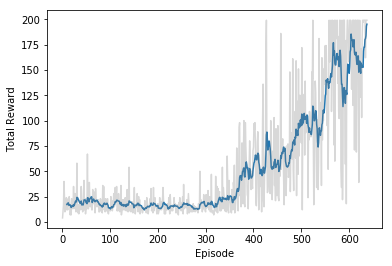

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Distributional Double Q Learning **

Applies Double Q learning to a distributional DQN.

In [0]:
import trfl

class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20, num_atoms=51, atom_min=-2.,atom_max=10.):
        with tf.variable_scope(name):
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.name = name
            
            #get the logits for the Distributional DQN
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size * num_atoms, 
                                                            activation_fn=None)
            #reshape output into distibutional logits (batch size x actions x num_atoms)
            self.logits_ = tf.reshape(self.output, [batch_size, action_size, num_atoms])
            
            #get atom values
            self.atom_values = self.get_atoms(num_atoms,atom_min,atom_max)
            self.atom_ = tf.constant(self.atom_values,dtype=tf.float32,shape=[num_atoms])
      
            #get action values
            #TRFL does the softmax to self.logits. We are not using TRFL to get greedy actions so need to add here
            self.normalized_values = tf.nn.softmax(self.logits_, axis=-1)
            #reduce sum over atoms, left with batch_size x action size. Can take argmax to get greedy actions
            self.action_values_ = tf.reduce_sum(self.normalized_values*self.atom_, axis=-1)
  
            #TRFL placeholders
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.target_logits_ = tf.placeholder(tf.float32, [batch_size,action_size,num_atoms], name='target')
            self.target_atom_ = tf.placeholder(tf.float32,[num_atoms])
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            self.train_next_ = tf.placeholder(tf.float32, [batch_size,action_size], name='train_next')
            
            #TRFL distributional
            qloss, q_learning = trfl.categorical_dist_double_qlearning(self.atom_, self.logits_, self.action_, self.reward_,
                                                                self.discount_, self.target_atom_, self.target_logits_,
                                                                      self.train_next_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
                      
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]
    
    def get_atoms(self, num_atoms, atom_min, atom_max):
      delta = (atom_max - atom_min)/(num_atoms-1)
      return [atom_min + i * delta for i in range(0, num_atoms)]

** TRFL Usage **

Like trfl.double_qlearning() compared to trfl.qlearning() an additional tensor of next state action values from the train network is added to the TRFL function. As before, we have an additional step in the session. We produce the train networks estimate of the next state values and input this into the self.train_next_ tensor.

In [9]:
# define hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount
action_size = env.action_space.n

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01             # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64              # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#Distributional RL parameters
num_atoms = 51
atom_min = -2.
atom_max = 10.

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size,
                  action_size=action_size, num_atoms=num_atoms)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size,
                   action_size=action_size, num_atoms=num_atoms)

#target network updating
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(),tau=1.0/update_target_every)

/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [0]:
from collections import deque

class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
      
# Initialize the simulation
env = gym.make("CartPole-v0")
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [11]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            sess.run(target_network_update_ops)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                np.array([state]*20)
                feed = {trainQN.input_: np.array([state]*batch_size)}
                Qs = sess.run(trainQN.action_values_,feed_dict=feed)
                action = np.argmax(Qs)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.5f}'.format(loss),
                        'Epsilon: {:.3f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            # use targetQN for the target values
            target_Qs = sess.run(targetQN.logits_, feed_dict={targetQN.input_: next_states})
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = np.zeros((np.sum(episode_ends),env.action_space.n,num_atoms))
            # get next state estimates for train network
            train_Qs = sess.run(trainQN.action_values_, feed_dict={trainQN.input_: next_states})
            # Set train_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            train_Qs[episode_ends] = (0, 0)
            
            # run TRFL in the session
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.target_logits_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions,
                                           trainQN.target_atom_:targetQN.atom_values,
                                           trainQN.train_next_: train_Qs})



Episode: 10 Total reward: 23.0 Training loss: 3.90705 Epsilon: 0.991
Episode: 20 Total reward: 13.0 Training loss: 3.83583 Epsilon: 0.981
Episode: 30 Total reward: 25.0 Training loss: 3.80492 Epsilon: 0.971
Episode: 40 Total reward: 17.0 Training loss: 3.79062 Epsilon: 0.961
Episode: 50 Total reward: 22.0 Training loss: 3.78446 Epsilon: 0.951
Episode: 60 Total reward: 25.0 Training loss: 3.77329 Epsilon: 0.942
Episode: 70 Total reward: 14.0 Training loss: 3.77223 Epsilon: 0.932
Episode: 80 Total reward: 11.0 Training loss: 3.76419 Epsilon: 0.922
Episode: 90 Total reward: 8.0 Training loss: 3.75870 Epsilon: 0.912
Episode: 100 Total reward: 12.0 Training loss: 3.74633 Epsilon: 0.902
Episode: 110 Total reward: 18.0 Training loss: 3.73403 Epsilon: 0.892
Episode: 120 Total reward: 22.0 Training loss: 3.73957 Epsilon: 0.882
Episode: 130 Total reward: 12.0 Training loss: 3.71333 Epsilon: 0.872
Episode: 140 Total reward: 11.0 Training loss: 3.69132 Epsilon: 0.862
Episode: 150 Total reward: 25.

Text(0, 0.5, 'Total Reward')

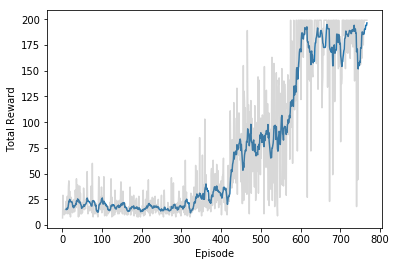

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')